<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

In [58]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!apt-get install tree
!tree '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_jpg/'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (163 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_jpg/
├── BraTS20_Training_001
│   ├── BraTS20_Training_001_flair-slice077.jpg
│   ├── BraTS20_Training_001_seg-slice077.jpg
│   ├── BraTS20_Training_001_t1ce-slice077.jpg
│   ├── BraTS20_Training_001_t1-slice077.jpg
│   └── BraTS20_Tra

In [4]:
# Učitaj CSV datoteku
survival_info = pd.read_csv('/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData/survival_info.csv')
survival_info.head(5)

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [5]:
name_mapping = pd.read_csv('/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData/name_mapping.csv')
name_mapping.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [6]:
# Povezivanje podataka prema različitim ključevima
merged_data = pd.merge(name_mapping, survival_info, left_on="BraTS_2020_subject_ID", right_on="Brats20ID", how="inner")
merged_data.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID,Brats20ID,Age,Survival_days,Extent_of_Resection
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001,BraTS20_Training_001,60.463,289,GTR
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002,BraTS20_Training_002,52.263,616,GTR
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003,BraTS20_Training_003,54.301,464,GTR
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004,BraTS20_Training_004,39.068,788,GTR
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005,BraTS20_Training_005,68.493,465,GTR


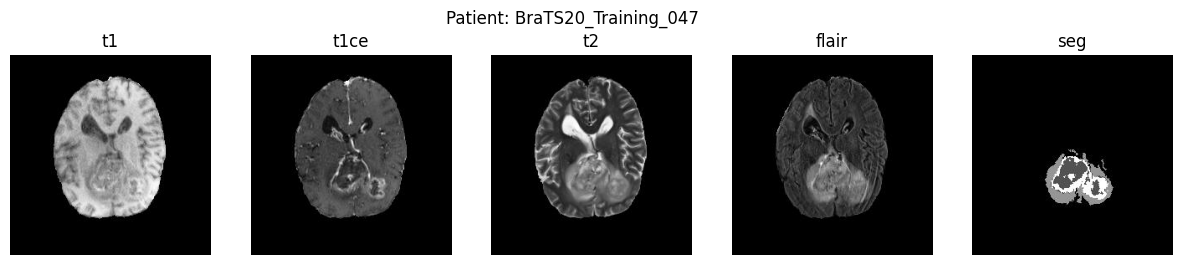

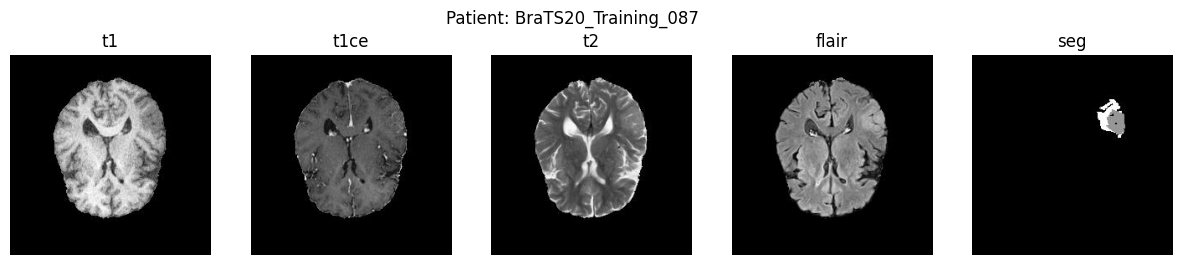

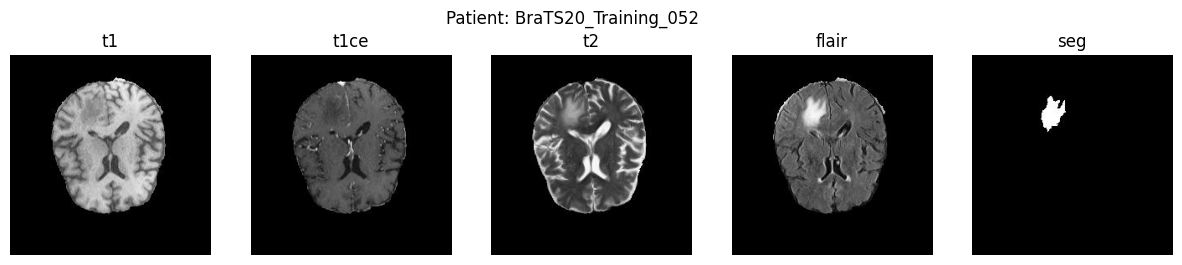

In [11]:
main_output_directory = '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_jpg/'

# Lista svih direktorija pacijenata u glavnom izlaznom direktoriju
patient_directories = [d for d in os.listdir(main_output_directory) if os.path.isdir(os.path.join(main_output_directory, d))]

# Nasumično odaberite 3 pacijenta
selected_patients = np.random.choice(patient_directories, size=3, replace=False)

# Funkcija za izdvajanje modality type iz naziva slike
def extract_modality_type(file_name):
    return file_name.split('_')[-1].split('-')[0]

# Prikazi slike za svakog odabrana pacijenta
for selected_patient in selected_patients:
    # Konstruiraj putanju do izlaznog direktorija odabranog pacijenta
    selected_patient_output_directory = os.path.join(main_output_directory, selected_patient)

    # Lista svih datoteka slika u izlaznom direktoriju odabranog pacijenta
    image_files = [f for f in os.listdir(selected_patient_output_directory) if f.endswith('.jpg')]

    # Sortiraj slike prema redoslijedu T1, T1CE, T2, FLAIR, seg
    image_files.sort(key=lambda x: ['t1', 't1ce', 't2', 'flair', 'seg'].index(extract_modality_type(x.lower())))

    # Prikazi svaku odabrane slike s povećanim razmakom
    plt.figure(figsize=(15, 3))
    for i, image_file in enumerate(image_files):
        # Izdvoji modality type pomoću funkcije
        modality_type = extract_modality_type(image_file)

        # Učitaj sliku
        img_path = os.path.join(selected_patient_output_directory, image_file)
        img = np.array(Image.open(img_path))

        plt.subplot(1, len(image_files), i + 1)
        plt.imshow(img, cmap='bone')
        plt.axis('off')
        plt.title(modality_type)

    plt.suptitle(f"Patient: {selected_patient}", fontsize=12)
    plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Učitajte spojeni skup podataka
merged_data = pd.merge(name_mapping, survival_info, left_on="BraTS_2020_subject_ID", right_on="Brats20ID", how="inner")

# Postavite putanju do direktorija sa slikama
image_dir = '/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_jpg/'

# Inicijalizirajte prazne liste za podatke i oznake
data = []
labels = []

for index, row in merged_data.iterrows():
    # Dobivanje ID-a pacijenta
    patient_id = row['BraTS_2020_subject_ID']

    # Konstruirajte putanju do direktorija pacijenta sa slikama
    patient_image_dir = os.path.join(image_dir, patient_id)

    # Provjerite jesu li poddirektoriji prisutni
    if os.path.isdir(patient_image_dir):
        try:
            # Učitajte slike i dodajte ih u podatke i oznake
            img_flair = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_flair-slice077.jpg')))
            img_t1 = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_t1-slice077.jpg')))
            img_t1ce = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_t1ce-slice077.jpg')))
            img_t2 = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_t2-slice077.jpg')))
            img_seg = np.array(Image.open(os.path.join(patient_image_dir, f'{patient_id}_seg-slice077.jpg')))

            # Dodajte slike u podatke i oznake
            data.append([img_flair, img_t1, img_t1ce, img_t2])
            labels.append(img_seg)

            # Ispis ID-a pacijenta ako je uspješno učitan
            print(f"Učitan pacijent: {patient_id}")

        except Exception as e:
            print(f"Greška pri učitavanju slika za pacijenta {patient_id}: {e}")

# Pretvorite liste u numpy nizove
data = np.array(data)
labels = np.array(labels)

# Provjerite dimenzije
print("Dimenzije skupa za učenje:", data.shape, labels.shape)

In [ ]:
# Prikazivanje minimalnih i maksimalnih vrijednosti piksela u slikama
print("Min i Max vrijednosti prije normalizacije:")
print("Flair:", np.min(data[:, 0]), np.max(data[:, 0]))
print("T1:", np.min(data[:, 1]), np.max(data[:, 1]))
print("T1CE:", np.min(data[:, 2]), np.max(data[:, 2]))
print("T2:", np.min(data[:, 3]), np.max(data[:, 3]))
print("Segmentation:", np.min(labels), np.max(labels))

In [ ]:
# Normalizacija na raspon [0, 1]
data_normalized = data / 255.0
labels_normalized = labels / 255.0

In [ ]:
# Prikazivanje minimalnih i maksimalnih vrijednosti piksela u slikama
print("Min i Max vrijednosti prije normalizacije:")
print("Flair:", np.min(data_normalized[:, 0]), np.max(data_normalized[:, 0]))
print("T1:", np.min(data_normalized[:, 1]), np.max(data_normalized[:, 1]))
print("T1CE:", np.min(data_normalized[:, 2]), np.max(data_normalized[:, 2]))
print("T2:", np.min(data_normalized[:, 3]), np.max(data_normalized[:, 3]))
print("Segmentation:", np.min(labels_normalized), np.max(labels_normalized))

In [ ]:
import torch
from torch.utils.data import Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            'image': self.data[idx].transpose(0, 3, 1, 2),  # Transponirajte dimenzije
            'mask': self.labels[idx]
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# Kreiranje instance klase BraTSDataset
brats_dataset = BrainTumorDataset(data_normalized, labels_normalized)

# Prikazivanje nekoliko uzoraka iz dataseta
for i in range(5):
    sample = brats_dataset[i]
    print(f"Uzorak {i + 1}:")
    print("Dimenzije slike:", sample['image'].shape)
    print("Dimenzije maske:", sample['mask'].shape)
    print("--------------------------------------------------")

In [ ]:
from sklearn.model_selection import train_test_split

# Podijeli podatke na skup za trening i skup za validaciju
train_data, val_data, train_labels, val_labels = train_test_split(data_normalized, labels_normalized, test_size=0.2, random_state=42)

# Provjerite dimenzije podataka za trening i validaciju
print("Dimenzije skupa za trening:", train_data.shape, train_labels.shape)
print("Dimenzije skupa za validaciju:", val_data.shape, val_labels.shape)

# Kreirajte DataLoader-e za trening i validaciju
batch_size = 32
train_dataset = BrainTumorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = BrainTumorDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("using gpu")
else:
    print("using cpu")

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 1, kernel_size=1)  # Output layer with 1 channel for segmentation
        )

    def forward(self, x):
        # Encoder pass
        x1 = self.encoder(x)
        # Decoder pass
        x2 = self.decoder(x1)
        return x2

# Create an instance of the UNet model
model = UNet()

# Print the model architecture
print(model)

# **NESTO**

In [122]:
imgs_dir='/content/drive/MyDrive/output_images/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)
all_dirs.sort()
# test_dirs = np.copy(all_dirs[45000:])
# all_dirs = all_dirs[:45000]
# len(all_dirs), all_dirs[:10]

In [123]:
def shuffle_split (all_dirs, val_pct = 0.15, seed = 99):
    """ shuffling dataset with random state and split to train and valid """
    n_val = int (len (all_dirs) * val_pct)
    np.random.seed (seed)
    idx = np.random.permutation (len (all_dirs))
    all_dirs = np.array (all_dirs) [idx]

    return all_dirs [n_val:], all_dirs [:n_val]

train_dirs, valid_dirs = shuffle_split (all_dirs, seed = 1)
len(valid_dirs), len(train_dirs)

(13, 76)

In [125]:
class BratsDataset(Dataset):
    def __init__(self, img_dirs, modality_types, transform=None):
        self.img_dirs = img_dirs
        self.transform = transform

    def __len__(self):
        return len(self.img_dirs)*154

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        # Update the mask file name format
        start_slice = 1  # Adjust this based on your dataset
        end_slice = 154  # Adjust this based on your dataset
        mask_filenames = [f'{patient_id}_{patient_id}_seg-slice{i:03d}.jpg' for i in range(start_slice, end_slice + 1)]

        mask = [np.array(Image.open(os.path.join(imgs_path, mask_filename))) for mask_filename in mask_filenames]
        mask = [(mask / 255 * 4).round() for mask in mask]
        mask = [self.preprocess_mask_labels(mask) for mask in mask]

        if self.transform is not None:
          augmented = self.transform(image=image, mask=mask)
          image = augmented['image']
          mask = augmented['mask']

        # Select only the first channel from the mask
        masks = [mask_i[..., 0] for mask_i in mask]

        return image.astype(float), np.array(mask).astype(float)

    def concat_imgs(self, path: str):
        patient_id = os.path.basename(path)  # Extracts the patient ID from the full path
        types = []
        modality_types = ['t2']  # Add other modalities if needed
        for modality_type in modality_types:
            for slice_number in range(1, 155):  # Adjust the range based on your needs
                img_filename = f'{patient_id}_{patient_id}_{modality_type}-slice{slice_number:03d}.jpg'
                img = np.array(Image.open(os.path.join(path, img_filename)))
                img = self.normalize(img)
                types.append(img)
        return np.array(types)

    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        # mask = np.moveaxis(mask, (0, 1, 2), (0, 2, 1))
        return mask

    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min

        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['flair', 't1', 't1ce', 't2']


In [126]:
# Training transformations
trn_tfms = A.Compose([
    A.Resize(height=240, width=240),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
    ToTensorV2(),
])

# Validation transformations
val_tfms = A.Compose([
    A.Resize(height=240, width=240),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
    ToTensorV2(),
])


In [131]:
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
train_dl = DataLoader(train_ds, batch_size = 8, shuffle = False, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = 8, shuffle = False, num_workers = 2, pin_memory = True)

In [133]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

#ENKODER
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

#DEKODER
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # self.activation = nn.Softmax()
    def forward(self, x):
        return self.conv(x)
        # return self.activation(self.conv(x))


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [134]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score


class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        return bce_loss + dice_loss

# helper functions for testing.
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

In [135]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : val_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, (images, targets) in enumerate(dataloader):
#             print(images.shape, targets.shape)
#             images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,

            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]}
            """,

            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]

        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")

    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)


In [140]:
batch_size = 4
train_dirs=train_dirs[:200]
valid_dirs=valid_dirs[:200]
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = False, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = False, num_workers = 2, pin_memory = True)
print(len(valid_dl ), len(train_dl))
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=4, bilinear=True).to(device).float()


501 2926


In [141]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

trainer = Trainer(net=model,
                  train_dl=train_dl,
                  val_dl=valid_dl,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=batch_size,
                  batch_size=batch_size,
                  num_epochs=10,
                 )


device: cuda


In [ ]:
%%time
trainer.run()

train epoch: 0 | time: 14:38:47
